Exercise 5.10

In [26]:
#import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import norm

In [27]:
logRet = pd.read_csv("m_logret_10stocks.txt", delimiter = "\t")
capmRef = pd.read_csv("m_sp500ret_3mtcm.txt", delim_whitespace = True)

In [28]:
#Need to make sure each column has the same return type: "log monthly returns"
capmRef['sp500'] = capmRef['sp500'].apply(lambda x: math.log(x+1))
capmRef['3mTCM'] = capmRef['3mTCM'].apply(lambda x: math.log((x/(100*12)) + 1))


In [41]:
capm = pd.concat([logRet, capmRef[['sp500', '3mTCM']]], axis = 1)
capm.head()

,Date,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL,sp500,3mTCM
0,1/3/1994,0.048913,0.135255,-0.022896,0.062311,-0.012589,0.089236,-0.004332,0.000000,0.023481,0.049109,0.013795,0.002480
1,2/1/1994,0.048849,-0.014934,-0.009507,0.020685,0.059586,-0.002166,-0.014386,-0.026850,-0.013543,0.010790,-0.013337,0.002705
2,3/1/1994,-0.040761,-0.078928,0.000873,0.162273,0.000000,-0.071433,-0.007948,0.014169,0.011634,-0.010790,-0.020546,0.002912
3,4/4/1994,-0.044394,0.041945,0.002175,-0.073436,-0.059586,-0.117886,0.002286,0.022294,0.038426,-0.031135,0.004967,0.003062
4,5/2/1994,-0.009572,0.031889,0.015763,0.010089,0.121734,-0.018289,0.003406,0.041424,0.064941,0.057625,0.005337,0.003444


In [30]:
capmAdjusted = capm
capmAdjusted = capmAdjusted.iloc[:, 1:12].subtract(capm['3mTCM'], axis = 'index')
capmAdjusted.head()

,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL,sp500
0,0.046433,0.132775,-0.025376,0.059831,-0.015069,0.086756,-0.006812,-0.002480,0.021001,0.046629,0.011315
1,0.046144,-0.017639,-0.012212,0.017980,0.056881,-0.004871,-0.017090,-0.029555,-0.016247,0.008086,-0.016042
2,-0.043673,-0.081841,-0.002039,0.159360,-0.002912,-0.074346,-0.010861,0.011257,0.008721,-0.013703,-0.023458
3,-0.047456,0.038883,-0.000887,-0.076498,-0.062648,-0.120948,-0.000776,0.019232,0.035364,-0.034197,0.001905
4,-0.013016,0.028445,0.012319,0.006645,0.118290,-0.021733,-0.000038,0.037979,0.061497,0.054181,0.001893


In [43]:
cutoffIdx = 54
period1Idx = range(0, cutoffIdx)
period2Idx = range(cutoffIdx, capmAdjusted.shape[0])
capmPeriod1 = capmAdjusted.iloc[period1Idx, :]
capmPeriod2 = capmAdjusted.iloc[period2Idx, :]


In [60]:
beta1 = [None]*(capmAdjusted.shape[1]-1)
beta2 = [None]*(capmAdjusted.shape[1]-1)
X1 = capmPeriod1['sp500'].to_numpy().reshape(-1,1)
X2 = capmPeriod2['sp500'].to_numpy().reshape(-1,1)
for idx in range(0, len(beta1)):
    y1 = capmPeriod1.iloc[:, idx].to_numpy().reshape(-1,1)
    y2 = capmPeriod2.iloc[:, idx].to_numpy().reshape(-1,1)
    model1 = sm.OLS(y1, X1)
    model2 = sm.OLS(y2, X2)
    beta1[idx] = model1.fit()
    beta2[idx] = model2.fit()

In [61]:
print(beta1[0].params)
print(beta2[0].params)

[0.51103433]
[1.61221165]


In [62]:
diffBeta = list()
zScoreBeta = list()
for i, j in zip(beta1, beta2):
    diff = (j.params - i.params)
    diffBeta.append(diff)
    zScoreBeta.append(diff/np.sqrt(i.bse**2 + j.bse**2))


hypothesisTest = [None]*len(zScoreBeta)
critical = norm.ppf(0.975)
for idx, i in enumerate(zScoreBeta):
    if i < -1*critical or i > critical:
        hypothesisTest[idx] = False
    else:
        hypothesisTest[idx] = True
for hyp, z in zip(hypothesisTest, zScoreBeta):
    print("{}  w/ z-val: {:5.3f}".format(hyp,np.ndarray.item(z)))

True  w/ z-val: 1.694
True  w/ z-val: 0.544
True  w/ z-val: 1.085
False  w/ z-val: 2.684
True  w/ z-val: -0.849
True  w/ z-val: 1.582
True  w/ z-val: 0.328
True  w/ z-val: 0.551
True  w/ z-val: 0.129
True  w/ z-val: 1.464


As we can see, only one of the stock's beta actually rejects the null hypothesis that the beta's are not significantly different from one period to the next; however, there are nearly 4 z-scores that seem nearly significant, so we can see that there definitely is some time-dependence of these variables. 

In [78]:
#Now lets try to estimate beta as a dynamic linear model, first lets create our subroutine 
#computing Kalman Filter values and estimates
def singleKalmanFilter(beta0, betaVariance, stockObs, marketObs, 
                       stateMSE, obsVariance):
    n = len(marketObs)
    dynamicBeta = [None]*n
    
    priorVariance_i = betaVariance
    priorBeta_i = beta0
    
    for i in range(0, n):
        K_i = computeKalman(stateMSE, priorVariance_i, marketObs.iloc[i])
        posteriorBeta = updatePriorBeta(priorBeta_i, K_i, marketObs.iloc[i], stockObs.iloc[i])
        posteriorVar_i = updatePriorVar(K_i, priorVariance_i, marketObs.iloc[i], obsVariance,
                                        stateMSE)
        estimateBeta_i = estimateBeta(priorBeta_i, priorVariance_i, marketObs.iloc[i],
                                   stateMSE, stockObs.iloc[i])
        
        priorBeta_i = posteriorBeta
        priorVariance_i = posteriorVar_i
        dynamicBeta[i] = estimateBeta_i
        
    return dynamicBeta


In [79]:
def computeKalman(stateMSE, priorVariance_i, marketObs):
    retval = priorVariance_i * marketObs
    retval /= (stateMSE + (priorVariance_i*(marketObs**2)))
    return retval
    
def updatePriorBeta(priorBeta_i, K_i, marketObs, stockObs):
    retval = priorBeta_i + K_i*(stockObs - priorBeta_i*marketObs)
    return retval
    
def updatePriorVar(K_i, priorVariance_i, marketObs, obsVariance, stateMSE):
    retval = ((1-K_i*marketObs)**2)*priorVariance_i
    retval += obsVariance + (K_i**2)*stateMSE
    return retval

def estimateBeta(priorBeta, priorVariance_i, marketObs, stateMSE, stockObs):
    retval = priorBeta + ((stockObs-marketObs*priorBeta)*(priorVariance_i*marketObs))/((marketObs**2)*priorVariance_i + stateMSE)
    return retval

In [82]:
#Lets Try it out on one of the stocks, AAPL
estimatedBeta = beta1[0].params
#intial value of P_o 
estimatedBetaVar = beta1[0].bse**2
stateMSE = beta1[0].mse_resid

#V_t should be mse_id of parameter value

obsVariance = 0.2**2
stockObs = capmPeriod2['AAPL']
marketObs = capmPeriod2['sp500']

dynamicBetaAAPL = singleKalmanFilter(estimatedBeta, estimatedBetaVar, stockObs,
                                    marketObs, stateMSE, obsVariance)


Text(0, 0.5, 'Dynamic Beta')

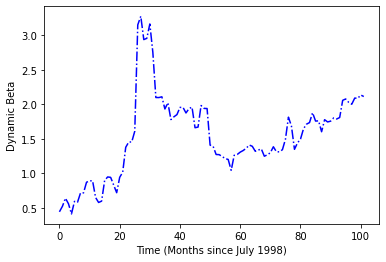

In [83]:
plt.plot(dynamicBetaAAPL, 'b-.')
plt.xlabel("Time (Months since July 1998)")
plt.ylabel("Dynamic Beta")

In [85]:
dynamicBetaList = [None]*(capmPeriod2.shape[1]-1)
for idx, i in enumerate(dynamicBetaList):
    estimatedBeta = beta1[idx].params
    estimatedBetaVar = beta1[idx].bse**2
    stateMSE = beta1[idx].mse_resid
    dynamicBetaList[idx] = singleKalmanFilter(estimatedBeta, estimatedBetaVar,
                                              capmPeriod2.iloc[:,idx], 
                                              capmPeriod2.iloc[:,-1], stateMSE,
                                              obsVariance)
    

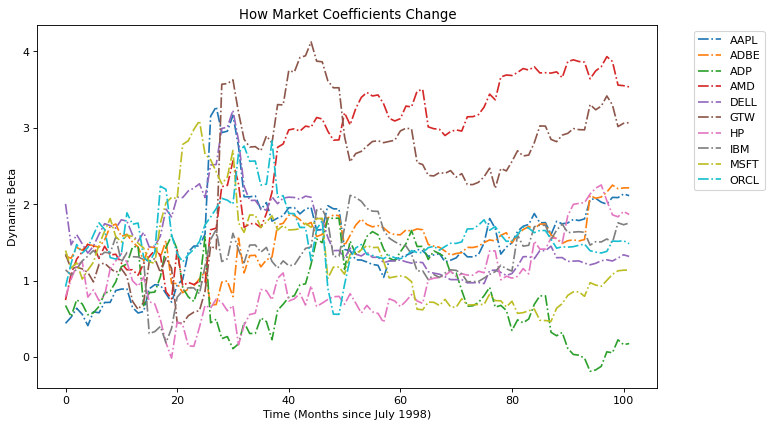

In [86]:
names = capmPeriod2.iloc[:, 0:-1].columns

plt.figure(figsize=(10,6), dpi=80)
plt.xlabel("Time (Months since July 1998)")
plt.ylabel("Dynamic Beta")
plt.title("How Market Coefficients Change")
for i in range(0, len(dynamicBetaList)):
    plt.plot(dynamicBetaList[i], '-.')
plt.legend(names, bbox_to_anchor=(1.05,1))
plt.show()

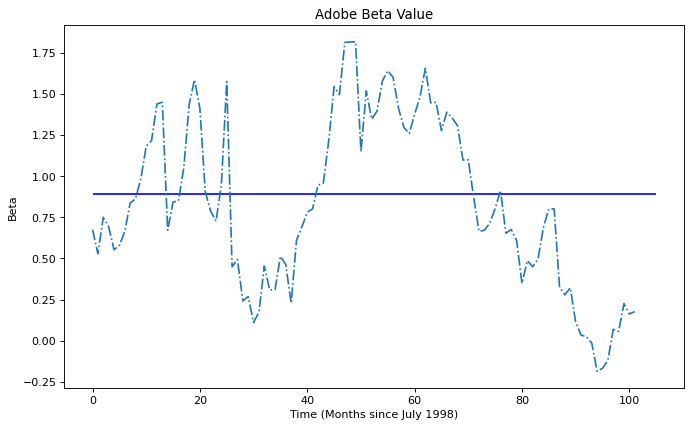

In [101]:
#lets see a visual representation of the two methods using the ADOBE stock.
plt.figure(figsize=(10,6), dpi = 80)
plt.xlabel("Time (Months since July 1998)")
plt.ylabel("Beta")
plt.title("Adobe Beta Value")
plt.plot(dynamicBetaList[2], '-.')
plt.hlines(y = beta2[2].params, xmin = 0, xmax = 105, color = 'b')

plt.show()

As we can see, the kalman filter Beta seems to oscillate around the value given by the OLS for the second period, almost like a random walk, and it should be noted this case is pretty represantitive of the rest of the stocks. With that being said, their is clearly a dynamic element to the value of Beta, and thus it makes sense to model the stocks relationship to the market as a dynamic process. Now let's see the residuals between the two methods for ADOBE. 

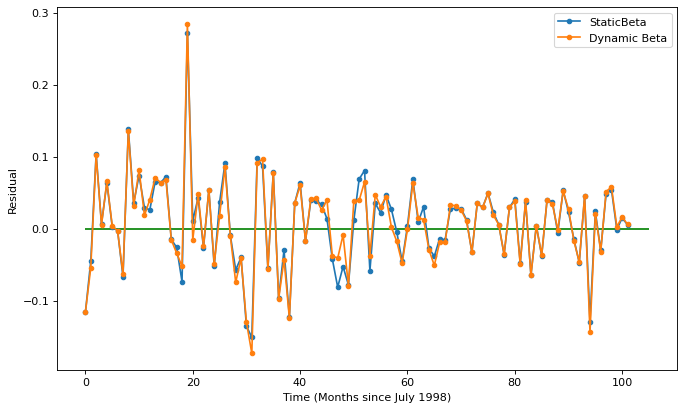

In [115]:
n = np.arange(start=0,stop=len(capmPeriod2['sp500']))
dynamicRes = np.empty(len(n))
staticRes = np.empty(len(n))


for i in range(0, len(n)):
    staticRes[i] = np.ndarray.item(capmPeriod2['ADBE'].iloc[i] - beta1[2].params*capmPeriod2['sp500'].iloc[i])
    dynamicRes[i] = np.ndarray.item(capmPeriod2['ADBE'].iloc[i] - dynamicBetaList[2][i]*capmPeriod2['sp500'].iloc[i])
    

plt.figure(figsize=(10,6), dpi = 80)
plt.xlabel("Time (Months since July 1998)")
plt.ylabel("Residual")
plt.plot(n, staticRes, marker = "o", markersize = 4, label = "StaticBeta")
plt.plot(n, dynamicRes, marker = "o", markersize = 4, label = "Dynamic Beta")
plt.hlines(y = 0, xmin = 0, xmax = 105, color = 'g')

plt.legend()


It appears that the residuals don't differ all that much over time regardless of whether or not we use a dynamic or static beta value.